# # VRP Variant Solver Comparison (8-Node Example)

# We will compare three methods for solving a profit-maximizing, duration-constrained vehicle routing problem variant on an 8-node graph:
# 1. Deep Reinforcement Learning (DRL) using DQN.
# 2. Mixed-Integer Programming (MIP) for the optimal solution.
# 3. A simple Greedy Heuristic (Best Reward/Time Ratio).

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical # For sampling actions
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import time
import pulp 
import math
import os

# # Define Constants (Adjusted for 8 Nodes)

In [27]:
#set input dates
date = "_2024-12-09"
truck = "VAN"
mpg = 6.5

In [28]:
# Specify the file name
file_name1 = "rate_q2_west_"+truck+date+".csv"
file_name2 = "duration_west.csv"
file_name3 = "prob_west_"+truck+date+".csv"
file_name4 = "load_av_west_"+truck+date+".csv"
file_name5 = "distance_west.csv"
file_name6 = "diesel_west"+date+".csv"
file_name7 = "labels_west.csv"
# Read the Excel file into a DataFrame
rate_matrix = pd.read_csv(file_name1,header= None)
time_matrix = pd.read_csv(file_name2,header = None)
markov_matrix = pd.read_csv(file_name3,header=None)
loads_matrix = pd.read_csv(file_name4,header=None)
distance_matrix = pd.read_csv(file_name5,header=None)
diesel_matrix = pd.read_csv(file_name6,header=None)
hub_labels = pd.read_csv(file_name7,header=None)

In [29]:
revenue_matrix = rate_matrix * distance_matrix
revenue_matrix[loads_matrix <= 1] = 0
diesel_matrix = diesel_matrix / mpg
var_cost_matrix = 1.2 * distance_matrix
cost_matrix = distance_matrix * diesel_matrix
cost_matrix = cost_matrix + 163
cost_matrix = cost_matrix + var_cost_matrix
reward_matrix = revenue_matrix - cost_matrix
time_matrix *= 0.9

In [30]:
NUM_NODES = 15
ACTION_SPACE_SIZE = NUM_NODES

# Problem Constraints (Keep the same duration limits for consistency)
DURATION_LIMIT = 60.0
DURATION_TOLERANCE = 0.10
MIN_DURATION = DURATION_LIMIT * (1 - DURATION_TOLERANCE)
MAX_DURATION = DURATION_LIMIT * (1 + DURATION_TOLERANCE)
BIG_M_PENALTY = -1e9 # Large negative number for rewards

# Use a fixed seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# ### Generate Sample Data

In [31]:
print(f"Generating sample data for {NUM_NODES} nodes...")
time_matrix = time_matrix.iloc[:NUM_NODES, :NUM_NODES]
reward_matrix = reward_matrix.iloc[:NUM_NODES, :NUM_NODES]
# Round for clarity
time_matrix = np.round(time_matrix, 1)
reward_matrix = np.round(reward_matrix, 0)

# Create DataFrames for easy viewing
time_df = pd.DataFrame(time_matrix, index=range(NUM_NODES), columns=range(NUM_NODES))
reward_df = pd.DataFrame(reward_matrix, index=range(NUM_NODES), columns=range(NUM_NODES))

print("\nSample Time Matrix (hours):")
print(time_df)
print("\nSample Reward Matrix:")
print(reward_df)

# Apply Big M penalty to reward matrix diagonal (used by DRL and Heuristic)
reward_matrix_penalized = reward_matrix.copy()
reward_array = reward_matrix_penalized.to_numpy()
np.fill_diagonal(reward_array, BIG_M_PENALTY)
reward_matrix_penalized = pd.DataFrame(reward_array, index=reward_matrix_penalized.index, columns=reward_matrix_penalized.columns)

Generating sample data for 15 nodes...

Sample Time Matrix (hours):
      0     1     2     3     4     5     6     7     8     9     10    11  \
0    0.0   3.4   4.2   5.4   3.7   1.7  19.1  11.5  13.3   9.3  14.8   8.4   
1    3.4   0.0   5.1   8.1   6.1   2.6  19.0  10.9  12.8  10.3  14.6   9.3   
2    4.1   5.1   0.0   8.8   6.9   2.8  15.8   7.8   9.7   6.2  11.5   5.3   
3    5.4   8.0   8.8   0.0   4.1   6.3  23.8  16.1  18.0  14.0  19.4  13.0   
4    3.6   6.1   6.9   4.1   0.0   4.4  21.9  14.2  16.1  12.1  17.5  10.7   
5    1.7   2.6   2.8   6.4   4.4   0.0  17.7  10.1  11.9   8.0  13.4   7.0   
6   19.0  19.0  15.9  23.7  21.7  17.7   0.0   8.1   6.3  10.1   4.7  12.0   
7   11.4  11.0   7.9  16.1  14.1  10.1   8.0   0.0   1.9   2.4   3.7   4.4   
8   13.2  12.8   9.6  17.9  15.9  11.9   6.3   1.9   0.0   4.2   2.4   6.2   
9    9.3  10.2   6.2  14.0  12.0   7.9  10.1   2.4   4.3   0.0   5.7   2.3   
10  14.7  14.6  11.5  19.4  17.4  13.3   4.7   3.7   2.4   5.7   0.0   7.7

# **Data Description:**
# * **Nodes:** 8 locations, indexed 0 through 7.
# * **Time Matrix:** Shows the travel time in hours between any two nodes `i` and `j` (`time_matrix[i][j]`). Times are generally between 2 and 15 hours and are slightly asymmetric (travel `i` to `j` might take slightly different time than `j` to `i`). Diagonal is 0.
# * **Reward Matrix:** Shows the reward (profit) gained by traveling between nodes `i` and `j` (`reward_matrix[i][j]`). Rewards range roughly from 50 to 500. There's a loose inverse correlation with time (shorter trips *tend* to have higher reward density) plus random noise. Diagonal is 0.
#
# **Goal Reminder:** For each starting node, find a route (cycle) that starts and ends at that node, maximizes total reward, and has a total duration around 60 hours.

## Part 2: DRL Implementation and Training
### DRL Hyperparameters and Agent Definition (Using PyTorch)

In [37]:
# DRL Hyperparameters (Can potentially reduce episodes/steps for smaller problem)
STATE_SIZE = 2 # (current_node_index, time_elapsed_normalized)
LEARNING_RATE = 0.001
GAMMA = 0.95 # Discount factor

EPSILON_START = 1.0
EPSILON_END = 0.05 # Can end higher for smaller problems
EPSILON_DECAY_STEPS = 5000 # Decay faster for smaller problems?

BUFFER_SIZE = 10000 # Smaller buffer might be okay
BATCH_SIZE = 32 # Smaller batch size

NUM_EPISODES = 58
MAX_STEPS_PER_EPISODE = 50 # Max steps per route attempt
TARGET_UPDATE_FREQ = 50 # Update target net more frequently

# Rewards / Penalties
RETURN_SUCCESS_BONUS = 100
TIME_VIOLATION_PENALTY = -1000
INCOMPLETE_PENALTY = -200

# PyTorch Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [9]:
# Q-Network Definition (Same as before)
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64) # Smaller network might suffice
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent_PyTorch:
    def __init__(self, state_size, action_size, learning_rate, gamma, buffer_size, batch_size, device):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.gamma = gamma
        self.batch_size = batch_size
        self.device = device

        # Use the smaller QNetwork
        self.policy_net = QNetwork(state_size, action_size).to(self.device)
        self.target_net = QNetwork(state_size, action_size).to(self.device)
        self.update_target_model()
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.loss_function = nn.MSELoss()
        self.epsilon = EPSILON_START

    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, invalid_actions=None): # Added invalid_actions parameter
        """Selects an action using epsilon-greedy strategy, avoiding invalid actions."""
        if invalid_actions is None:
            invalid_actions = set()

        current_node_index = int(state[0]) # Assuming state[0] is node index

        # Add current node itself to invalid actions for this step
        current_step_invalid_actions = invalid_actions.union({current_node_index})

        possible_actions = list(range(self.action_size))
        valid_actions = [a for a in possible_actions if a not in current_step_invalid_actions]

        # If no valid actions are possible (shouldn't normally happen unless trapped)
        if not valid_actions:
            # Fallback: maybe allow returning home if that's the only invalid action?
            # Or just return a dummy action (e.g., 0) - the environment should handle this.
            # Let's return current_node to signal being stuck, though env should handle.
             # print(f"Warning: No valid actions from node {current_node_index} with invalid set {current_step_invalid_actions}")
             return current_node_index # Return current node to signal being stuck

        if random.random() <= self.epsilon:
            # Explore: Choose randomly from valid actions
            return random.choice(valid_actions)
        else:
            # Exploit: Choose the best action from Q-values among valid ones
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.policy_net.eval()
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            self.policy_net.train()

            q_values_numpy = q_values.cpu().data.numpy()[0]

            # Mask invalid actions by setting their Q-values to -infinity
            for invalid_action in current_step_invalid_actions:
                 if 0 <= invalid_action < self.action_size:
                      q_values_numpy[invalid_action] = -np.inf

            # Choose the best among the remaining valid actions
            best_action = np.argmax(q_values_numpy)

            # Sanity check if argmax still picked an invalid action (e.g., all are -inf)
            if q_values_numpy[best_action] == -np.inf:
                 # print(f"Warning: All valid actions have -inf Q-value from node {current_node_index}. Choosing randomly from valid.")
                 # Fallback to random choice among valid if exploitation leads nowhere
                 if valid_actions: # Ensure valid_actions is not empty
                    return random.choice(valid_actions)
                 else: # Truly stuck
                    return current_node_index # Signal stuck

            return best_action

    def replay(self):
        if len(self.memory) < self.batch_size:
            return 0.0
        minibatch = random.sample(self.memory, self.batch_size)
        states = torch.from_numpy(np.vstack([e[0] for e in minibatch])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in minibatch])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in minibatch])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in minibatch])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in minibatch]).astype(np.uint8)).float().to(self.device)

        with torch.no_grad():
            target_q_next = self.target_net(next_states)
            max_q_next = target_q_next.max(1)[0].unsqueeze(1)
            target_q_values = rewards + (self.gamma * max_q_next * (1 - dones))

        current_q_values = self.policy_net(states)
        action_q_values = current_q_values.gather(1, actions)
        loss = self.loss_function(action_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def decay_epsilon(self, current_step):
         self.epsilon = max(EPSILON_END, EPSILON_START - (EPSILON_START - EPSILON_END) * (current_step / EPSILON_DECAY_STEPS))

    def load(self, path):
        try:
             self.policy_net.load_state_dict(torch.load(path, map_location=self.device))
             self.update_target_model()
             print(f"Model weights loaded from {path}")
        except Exception as e:
             print(f"Error loading model weights: {e}")

    def save(self, path):
        try:
             os.makedirs(os.path.dirname(path), exist_ok=True)
             torch.save(self.policy_net.state_dict(), path)
             print(f"Model weights saved to {path}")
        except Exception as e:
             print(f"Error saving model weights: {e}")

### DRL Training Loop

In [38]:
drl_agent = DQNAgent_PyTorch(state_size=STATE_SIZE,
                           action_size=ACTION_SPACE_SIZE,
                           learning_rate=LEARNING_RATE,
                           gamma=GAMMA,
                           buffer_size=BUFFER_SIZE,
                           batch_size=BATCH_SIZE,
                           device=device)

# Training History
drl_episode_rewards = []
drl_episode_losses = []
drl_total_steps = 0
drl_start_train_time = time.time()

print("Starting DRL Training...")

for start_node in range(0,7):
    print(start_node)
    for episode in range(NUM_EPISODES):
        current_node = start_node
        time_elapsed = 0.0
        state = np.array([current_node, time_elapsed / MAX_DURATION], dtype=np.float32)

        episode_reward = 0
        episode_loss_sum = 0
        steps_in_episode = 0
        done = False

        for step in range(MAX_STEPS_PER_EPISODE):
            action = drl_agent.act(state)
            next_node = action
            step_time = time_matrix[current_node][next_node]
            # Use penalized reward matrix for DRL training decisions (implicitly via learned Q)
            # but store experience based on actual rewards + terminal bonus/penalty
            step_reward = reward_matrix[current_node][next_node] # Base reward for the step

            next_time_elapsed = time_elapsed + step_time
            next_state = np.array([next_node, min(next_time_elapsed, MAX_DURATION) / MAX_DURATION], dtype=np.float32)

            terminal_reward = 0
            done = False

            # Termination checks (Same logic as before)
            if next_node == start_node:
                if MIN_DURATION <= next_time_elapsed <= MAX_DURATION:
                    terminal_reward = RETURN_SUCCESS_BONUS
                    done = True
                elif next_time_elapsed < MIN_DURATION:
                    terminal_reward = INCOMPLETE_PENALTY
                    done = True
                else: # > MAX_DURATION
                    terminal_reward = TIME_VIOLATION_PENALTY
                    done = True
            elif next_time_elapsed > MAX_DURATION:
                terminal_reward = TIME_VIOLATION_PENALTY
                done = True

            # Total reward for the experience tuple
            total_reward_experience = step_reward + terminal_reward

            drl_agent.remember(state, action, total_reward_experience, next_state, done)

            state = next_state
            current_node = next_node
            time_elapsed = next_time_elapsed
            episode_reward += step_reward # Track sum of actual step rewards
            steps_in_episode += 1
            drl_total_steps += 1

            drl_agent.decay_epsilon(drl_total_steps)
            loss = drl_agent.replay()
            if loss > 0: episode_loss_sum += loss
            if drl_total_steps % TARGET_UPDATE_FREQ == 0: drl_agent.update_target_model()
            if done:
                episode_reward += terminal_reward # Add final bonus/penalty for logging
                break

        drl_episode_rewards.append(episode_reward)
        avg_loss = episode_loss_sum / steps_in_episode if steps_in_episode > 0 else 0
        drl_episode_losses.append(avg_loss)

        if (episode + 1) % (NUM_EPISODES // 10) == 0: # Print progress 10 times
            print(f"DRL Episode: {episode + 1}/{NUM_EPISODES}, Steps: {steps_in_episode}, Total Steps: {drl_total_steps}, Reward: {episode_reward:.0f}, Avg Loss: {avg_loss:.4f}, Epsilon: {drl_agent.epsilon:.3f}")

    drl_training_time = time.time() - drl_start_train_time
    print(f"\nDRL Training Finished. Total time: {drl_training_time:.2f} seconds")

Starting DRL Training...
0
DRL Episode: 5/58, Steps: 6, Total Steps: 27, Reward: -258, Avg Loss: 0.0000, Epsilon: 0.995
DRL Episode: 10/58, Steps: 6, Total Steps: 51, Reward: -2029, Avg Loss: 549515.4062, Epsilon: 0.990
DRL Episode: 15/58, Steps: 8, Total Steps: 83, Reward: -3004, Avg Loss: 499875.6250, Epsilon: 0.984
DRL Episode: 20/58, Steps: 5, Total Steps: 112, Reward: 237, Avg Loss: 562016.6312, Epsilon: 0.979
DRL Episode: 25/58, Steps: 4, Total Steps: 141, Reward: -1952, Avg Loss: 502485.7578, Epsilon: 0.973
DRL Episode: 30/58, Steps: 6, Total Steps: 173, Reward: 10, Avg Loss: 389903.5417, Epsilon: 0.967
DRL Episode: 35/58, Steps: 6, Total Steps: 203, Reward: -280, Avg Loss: 345311.9453, Epsilon: 0.961
DRL Episode: 40/58, Steps: 3, Total Steps: 227, Reward: -306, Avg Loss: 387305.3438, Epsilon: 0.957
DRL Episode: 45/58, Steps: 4, Total Steps: 256, Reward: -905, Avg Loss: 441669.9062, Epsilon: 0.951
DRL Episode: 50/58, Steps: 7, Total Steps: 284, Reward: -1411, Avg Loss: 333547.92

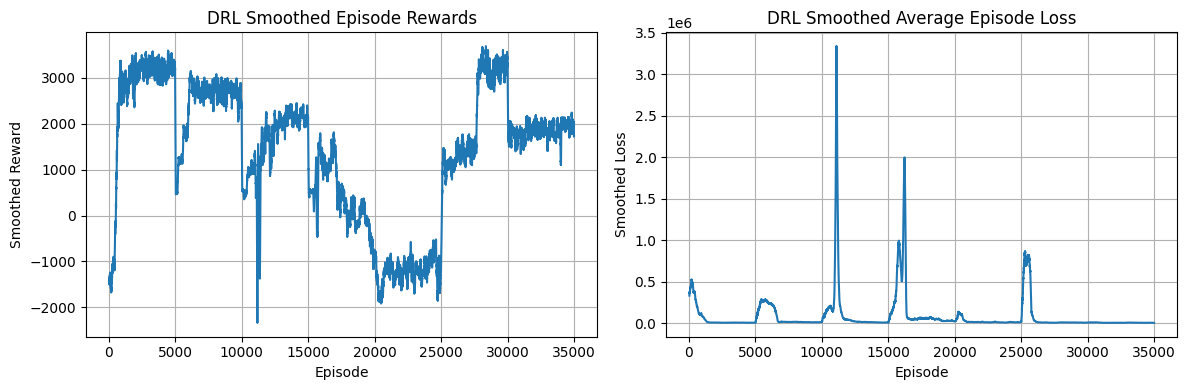

In [33]:
# Plot DRL Training Progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(pd.Series(drl_episode_rewards).rolling(50).mean()) # Smoothed rewards
plt.title('DRL Smoothed Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Smoothed Reward')
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(pd.Series(drl_episode_losses).rolling(50).mean()) # Smoothed loss
plt.title('DRL Smoothed Average Episode Loss')
plt.xlabel('Episode')
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

### DRL Route Generation Function (Same as before)

In [12]:
def generate_optimal_route_pytorch(agent, start_node, time_matrix, reward_matrix, max_steps=2*NUM_NODES):
    """
    Generates a route using the learned policy (greedy selection),
    preventing revisits to intermediate nodes.
    If max_steps is reached, attempts forced return if valid.
    Validates final duration window.
    """
    agent.epsilon = 0
    agent.policy_net.eval()
    current_node = start_node
    time_elapsed = 0.0
    state = np.array([current_node, time_elapsed / MAX_DURATION], dtype=np.float32)
    route = [start_node]
    visited_intermediate_nodes = set() # Keep track of nodes visited *other than* start_node
    total_reward = 0.0
    returned_home = False

    with torch.no_grad():
        for step in range(max_steps):
            # --- Action Selection ---
            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(agent.device)
            q_values = agent.policy_net(state_tensor)
            q_values_numpy = q_values.cpu().data.numpy()[0]

            # --- Masking Invalid Actions ---
            # 1. Don't stay in the same node
            q_values_numpy[current_node] = -np.inf

            # 2. Don't visit intermediate nodes already visited
            for visited_node_idx in visited_intermediate_nodes:
                 if 0 <= visited_node_idx < len(q_values_numpy): # Bounds check
                      q_values_numpy[visited_node_idx] = -np.inf

            # --- Choose Best Valid Action ---
            next_node = np.argmax(q_values_numpy)

            # Check if any valid action exists
            if q_values_numpy[next_node] == -np.inf:
                 # No valid moves possible (maybe all unvisited nodes violate time or Q-values are terrible)
                 # Try forcing return home immediately if possible
                 # print(f"DRL: Stuck at node {current_node}. No valid non-visited moves. Trying return home.")
                 if current_node != start_node:
                     return_time = time_matrix[current_node][start_node]
                     if time_elapsed + return_time <= MAX_DURATION + 1e-6:
                         next_node = start_node # Override choice to return home
                         # print("DRL: Forcing return home as only option.")
                     else:
                        # print(f"DRL Error: Stuck at node {current_node}. Cannot return home within duration.")
                        returned_home = False
                        break # Cannot proceed
                 else: # Stuck at start node? Should not happen if mask works.
                    returned_home = False
                    break


            # --- Simulate Step ---
            step_time = time_matrix[current_node][next_node]
            step_reward = reward_matrix[current_node][next_node]

            # --- Check immediate time violation (should be less likely now with stuck check) ---
            if time_elapsed + step_time > MAX_DURATION + 1e-6 and next_node != start_node:
                 # print(f"DRL: Next step to {next_node} violates MAX_DURATION. Stopping.")
                 returned_home = False
                 break

            # --- Update State ---
            time_elapsed += step_time
            total_reward += step_reward
            current_node = next_node
            route.append(current_node)
            # Add to visited set *only if* it's not the start node
            if current_node != start_node:
                visited_intermediate_nodes.add(current_node)

            state = np.array([current_node, min(time_elapsed, MAX_DURATION) / MAX_DURATION], dtype=np.float32)

            # --- Check for Natural Return ---
            if current_node == start_node:
                returned_home = True
                break

        # --- End of Step Loop ---

        # --- Handle Forced Return if max_steps reached ---
        # (This logic might be less necessary now but keep as fallback)
        if not returned_home and current_node != start_node:
            # print(f"DRL: Max steps reached, attempting forced return from {current_node} to {start_node}")
            return_time = time_matrix[current_node][start_node]
            return_reward = reward_matrix[current_node][start_node]
            if time_elapsed + return_time <= MAX_DURATION + 1e-6:
                time_elapsed += return_time
                total_reward += return_reward
                current_node = start_node
                route.append(start_node)
                returned_home = True
            # else: # Forced return violates time
                # returned_home remains False

    # --- Final Validation ---
    agent.policy_net.train()

    is_cycle = returned_home and route[0] == start_node and route[-1] == start_node and len(route)>1

    if not is_cycle:
        return None, -np.inf, np.inf # Failed route

    is_valid_duration = MIN_DURATION <= time_elapsed <= MAX_DURATION

    # Check for duplicate intermediate nodes (should be prevented by logic above)
    intermediate_nodes = route[1:-1]
    has_duplicates = len(intermediate_nodes) != len(set(intermediate_nodes))
    if has_duplicates:
         print(f"Warning: DRL route {route} has duplicate intermediate nodes despite masking!")
         # Treat as invalid? Or just note it. Let's return it but validity check below will fail if needed.

    if is_valid_duration and not has_duplicates:
        return route, total_reward, time_elapsed # Valid cycle found
    else:
        # Cycle formed, but duration or node visit is invalid
        return route, total_reward, time_elapsed # Return invalid route details

## Part 3: MIP Formulation and Solution (using PuLP)

In [13]:
def solve_mip(start_node, time_m, reward_m, min_d, max_d, num_n):
    """Solves the VRP variant using MIP for a given start node."""
    nodes = list(range(num_n))
    other_nodes = [n for n in nodes if n != start_node]

    # Create the model
    prob = pulp.LpProblem(f"VRP_Cycle_{start_node}", pulp.LpMaximize)

    # Decision Variables
    x = pulp.LpVariable.dicts("Route", (nodes, nodes), 0, 1, pulp.LpBinary)
    u = pulp.LpVariable.dicts("MTZ", nodes, 1, num_n - 1, pulp.LpContinuous)

    # Objective Function
    prob += pulp.lpSum(reward_m[i][j] * x[i][j] for i in nodes for j in nodes if i != j)

    # Constraints
    # 1. Degree Constraints
    for k in nodes:
        prob += pulp.lpSum(x[k][j] for j in nodes if k != j) == pulp.lpSum(x[j][k] for j in nodes if k != j)
        if k == start_node:
            prob += pulp.lpSum(x[start_node][j] for j in nodes if j != start_node) == 1
            prob += pulp.lpSum(x[j][start_node] for j in nodes if j != start_node) == 1
        else:
             prob += pulp.lpSum(x[j][k] for j in nodes if j != k) <= 1

    # 2. Duration Constraints
    total_time = pulp.lpSum(time_m[i][j] * x[i][j] for i in nodes for j in nodes if i != j)
    prob += total_time >= min_d
    prob += total_time <= max_d

    # 3. Subtour Elimination (MTZ)
    for i in other_nodes:
        prob += u[i] >= 1
        for j in other_nodes:
            if i != j:
                 prob += u[i] - u[j] + 1 <= (num_n - 1) * (1 - x[i][j])

    # Solve the problem
    solver = pulp.PULP_CBC_CMD(msg=0)
    prob.solve(solver)

    # Extract results
    status = pulp.LpStatus[prob.status]
    route = None
    total_reward = -np.inf
    total_duration = np.inf

    if status == 'Optimal':
        total_reward = pulp.value(prob.objective)
        total_duration = pulp.value(total_time)

        # --- Modified Route Reconstruction ---
        try: # Add a try-except block for safety during reconstruction
            current_node = start_node
            route = [start_node]
            visited_count = 0 # Safety counter

            while visited_count <= num_n: # Limit search depth
                found_next = False
                for j in nodes:
                    # Check if arc variable exists, is not None, and is selected (> 0.99)
                    # Also ensure j is not the current node
                    if j != current_node and \
                       x[current_node][j] is not None and \
                       x[current_node][j].varValue is not None and \
                       x[current_node][j].varValue > 0.99:

                        route.append(j)
                        current_node = j
                        found_next = True
                        break # Move to the next node in the path

                visited_count += 1

                if current_node == start_node: # Successfully completed the cycle
                    break
                if not found_next: # Dead end found during reconstruction
                    # print(f"MIP Route Reconstruction Error: Dead end at node {current_node} for start {start_node}.")
                    route = None # Invalid route
                    break
                if visited_count > num_n: # Avoid infinite loops / too many steps
                    # print(f"MIP Route Reconstruction Error: Route too long for start {start_node}. Path: {route}")
                    route = None # Invalid route
                    break

            # Final validation of reconstructed route
            if route is None or route[0] != start_node or route[-1] != start_node:
                 # print(f"MIP Route Reconstruction resulted in invalid path for start {start_node}. Route: {route}")
                 route = None
                 # If route is invalid, reset reward/duration derived from MIP objective
                 total_reward = -np.inf
                 total_duration = np.inf
                 status = 'Error_In_Route' # Update status to reflect this

        except Exception as e:
            print(f"Exception during MIP route reconstruction for start {start_node}: {e}")
            route = None
            total_reward = -np.inf
            total_duration = np.inf
            status = 'Error_Exception'
        # --- End of Modified Route Reconstruction ---

    # Ensure reward/duration are consistent if route is None
    if route is None:
         total_reward = -np.inf
         total_duration = np.inf
         # Update status if it was 'Optimal' but route failed
         if status == 'Optimal': status = 'Optimal_Route_Fail'


    return status, route, total_reward, total_duration

## Part 4: Simple Greedy Heuristic

In [14]:
def solve_heuristic(start_node, time_m, reward_m, min_d, max_d, num_n):
    """Solves using a greedy heuristic (Best Reward/Time Ratio)."""
    current_node = start_node
    time_elapsed = 0.0
    total_reward = 0.0
    route = [start_node]
    visited = {start_node}

    max_steps = num_n * 2 # Safety break

    for _ in range(max_steps):
        best_ratio = -np.inf
        best_next_node = -1
        candidates = []

        # Find potential next nodes and their ratios
        for next_node in range(num_n):
            if next_node != current_node and next_node not in visited:
                step_time = time_m[current_node][next_node]
                step_reward = reward_m[current_node][next_node] # Use non-penalized rewards

                if step_reward == BIG_M_PENALTY: continue # Skip penalized self-loops if any

                # Check if adding this step exceeds max duration
                if time_elapsed + step_time <= max_d:
                    if step_time > 1e-6: # Avoid division by zero
                        ratio = step_reward / step_time
                    else:
                        ratio = np.inf # Prioritize zero-time moves if rewarding

                    candidates.append({'node': next_node, 'ratio': ratio, 'time': step_time, 'reward': step_reward})

        # Sort candidates by ratio (highest first)
        candidates.sort(key=lambda x: x['ratio'], reverse=True)

        selected_move = None
        if candidates:
            selected_move = candidates[0] # Choose best ratio move initially
        # else: # No valid moves that don't exceed max duration or all nodes visited
            # Try returning home directly if not already home
            if current_node != start_node:
                 return_time = time_m[current_node][start_node]
                 return_reward = reward_m[current_node][start_node]
                 if time_elapsed + return_time <= max_d:
                     selected_move = {'node': start_node, 'time': return_time, 'reward': return_reward}
                 # else: No valid move possible, loop will terminate

        if selected_move:
            next_n = selected_move['node']
            time_elapsed += selected_move['time']
            total_reward += selected_move['reward']
            current_node = next_n
            route.append(next_n)
            if next_n != start_node:
                visited.add(next_n)

            if current_node == start_node: # Completed a cycle
                break
        else:
            # No move possible (either stuck or only invalid moves remaining)
            break # Exit loop

    # Final validation
    status = "Infeasible"
    is_valid = False
    if route[-1] == start_node and len(route) > 1: # Check if it's a cycle
        status = "Optimal" # Heuristic found a valid solution
        is_valid = True
    else:
        status = "Feasible_Invalid_Duration" # Found cycle, wrong duration
    # else: Route did not end at start node


    return status, route, total_reward, time_elapsed, is_valid

## Part 5: Evaluation and Comparison

In [39]:
results = []
mip_times = []
heuristic_times = []
drl_inference_times = []

print("\n--- Running Solvers for Each Start Node ---")

for s_node in range(NUM_NODES):
    print(f"Solving for Start Node: {s_node}")
    result_row = {'Start Node': s_node}

    # Solve with DRL
    t0 = time.time()
    drl_route, drl_reward, drl_duration = generate_optimal_route_pytorch(drl_agent, s_node, time_matrix, reward_matrix)
    drl_inference_times.append(time.time() - t0)
    result_row['DRL Route'] = drl_route
    result_row['DRL Reward'] = drl_reward if drl_route else -np.inf
    result_row['DRL Duration'] = drl_duration if drl_route else np.inf
    result_row['DRL Valid'] = drl_route is not None and drl_route[0] == drl_route[-1]

    # Solve with MIP
    t0 = time.time()
    # Use original (non-penalized) reward matrix for MIP objective
    mip_status, mip_route, mip_reward, mip_duration = solve_mip(s_node, time_matrix, reward_matrix, MIN_DURATION, MAX_DURATION, NUM_NODES)
    mip_times.append(time.time() - t0)
    result_row['MIP Status'] = mip_status
    result_row['MIP Route'] = mip_route
    result_row['MIP Reward'] = mip_reward if mip_status == 'Optimal' else -np.inf
    result_row['MIP Duration'] = mip_duration if mip_status == 'Optimal' else np.inf
    result_row['MIP Valid'] = mip_status == 'Optimal' and mip_route is not None

    # Solve with Heuristic
    t0 = time.time()
    # Use original reward matrix for heuristic evaluation
    heu_status, heu_route, heu_reward, heu_duration, heu_valid = solve_heuristic(s_node, time_matrix, reward_matrix, MIN_DURATION, MAX_DURATION, NUM_NODES)
    heuristic_times.append(time.time() - t0)
    result_row['Heuristic Route'] = heu_route
    result_row['Heuristic Reward'] = heu_reward if heu_valid else (heu_reward if heu_route else -np.inf) # Show reward even if duration invalid
    result_row['Heuristic Duration'] = heu_duration if heu_route else np.inf
    result_row['Heuristic Valid'] = heu_valid

    # Calculate Optimality Gaps (relative to MIP if MIP is optimal)
    mip_opt_reward = result_row['MIP Reward']
    if result_row['MIP Valid']:
        drl_gap = ((mip_opt_reward - result_row['DRL Reward']) / abs(mip_opt_reward)) * 100 if abs(mip_opt_reward) > 1e-6 and result_row['DRL Valid'] else float('nan')
        heu_gap = ((mip_opt_reward - result_row['Heuristic Reward']) / abs(mip_opt_reward)) * 100 if abs(mip_opt_reward) > 1e-6 and result_row['Heuristic Valid'] else float('nan')
    else:
        drl_gap = float('nan')
        heu_gap = float('nan')

    result_row['DRL Gap (%)'] = drl_gap
    result_row['Heuristic Gap (%)'] = heu_gap

    results.append(result_row)


--- Running Solvers for Each Start Node ---
Solving for Start Node: 0
Solving for Start Node: 1
Solving for Start Node: 2
Solving for Start Node: 3
Solving for Start Node: 4
Solving for Start Node: 5
Solving for Start Node: 6
Solving for Start Node: 7
Solving for Start Node: 8
Solving for Start Node: 9
Solving for Start Node: 10
Solving for Start Node: 11
Solving for Start Node: 12
Solving for Start Node: 13
Solving for Start Node: 14


### Results Summary Table

In [40]:
results_df = pd.DataFrame(results)
# Format gaps for display
results_df['DRL Gap (%)'] = results_df['DRL Gap (%)'].map('{:.1f}'.format, na_action='ignore')
results_df['Heuristic Gap (%)'] = results_df['Heuristic Gap (%)'].map('{:.1f}'.format, na_action='ignore')

# Select and reorder columns for better readability
summary_cols = [
    'Start Node',
    'MIP Status', 'MIP Reward', 'MIP Valid', #'MIP Route',
    'DRL Reward', 'DRL Valid', 'DRL Gap (%)', #'DRL Route',
    'Heuristic Reward', 'Heuristic Valid', 'Heuristic Gap (%)', #'Heuristic Route'
]
print("\n--- Comparison Summary ---")
print(results_df[summary_cols].round(1)) # Round rewards/durations

# Display routes for a specific node if needed
print("\nExample Routes for Start Node 0:")
print("MIP:", results_df.loc[0, 'MIP Route'])
print("DRL:", results_df.loc[0, 'DRL Route'])
print("Heuristic:", results_df.loc[0, 'Heuristic Route'])


--- Comparison Summary ---
    Start Node MIP Status  MIP Reward  MIP Valid  DRL Reward  DRL Valid  \
0            0    Optimal      3365.0       True        30.0       True   
1            1    Optimal      3365.0       True      -395.0       True   
2            2    Optimal      3365.0       True       155.0       True   
3            3    Optimal      3365.0       True        -inf      False   
4            4    Optimal      3365.0       True      -290.0       True   
5            5    Optimal      3365.0       True      -489.0       True   
6            6    Optimal      2392.0       True        -inf      False   
7            7    Optimal      3061.0       True       551.0       True   
8            8    Optimal      2597.0       True      -361.0       True   
9            9    Optimal      3061.0       True       388.0       True   
10          10    Optimal      2467.0       True      -332.0       True   
11          11    Optimal      3061.0       True       551.0       True 

### Aggregate Performance Metrics

In [41]:
print("\n--- Aggregate Performance ---")

# Success Rates (finding a valid route)
mip_success = results_df['MIP Valid'].mean() * 100
drl_success = results_df['DRL Valid'].mean() * 100
heu_success = results_df['Heuristic Valid'].mean() * 100
print(f"Success Rate (Valid Route Found):")
print(f"  MIP:       {mip_success:.1f}%")
print(f"  DRL:       {drl_success:.1f}%")
print(f"  Heuristic: {heu_success:.1f}%")

# Average Rewards (only for valid routes found by respective method)
avg_mip_reward = results_df.loc[results_df['MIP Valid'], 'MIP Reward'].mean()
avg_drl_reward = results_df.loc[results_df['DRL Valid'], 'DRL Reward'].mean()
avg_heu_reward = results_df.loc[results_df['Heuristic Valid'], 'Heuristic Reward'].mean()
print(f"\nAverage Reward (for valid routes found):")
print(f"  MIP:       {avg_mip_reward:.1f}")
print(f"  DRL:       {avg_drl_reward:.1f}")
print(f"  Heuristic: {avg_heu_reward:.1f}")

# Average Optimality Gap (only for cases where MIP found optimal & method found valid)
# Convert gaps back to numeric for calculation
results_df['DRL Gap (%)'] = pd.to_numeric(results_df['DRL Gap (%)'], errors='coerce')
results_df['Heuristic Gap (%)'] = pd.to_numeric(results_df['Heuristic Gap (%)'], errors='coerce')

avg_drl_gap = results_df['DRL Gap (%)'].mean() # Mean ignores NaN by default
avg_heu_gap = results_df['Heuristic Gap (%)'].mean()
print(f"\nAverage Optimality Gap (vs MIP, when both valid):")
print(f"  DRL:       {avg_drl_gap:.1f}%")
print(f"  Heuristic: {avg_heu_gap:.1f}%")

# Computation Times
print("\n--- Computation Times ---")
print(f"DRL Training:          {drl_training_time:.2f} seconds (Total)")
print(f"Average MIP Solve Time: {np.mean(mip_times):.3f} seconds per instance")
print(f"Average DRL Infer Time: {np.mean(drl_inference_times):.4f} seconds per instance")
print(f"Average Heuristic Time: {np.mean(heuristic_times):.4f} seconds per instance")


--- Aggregate Performance ---
Success Rate (Valid Route Found):
  MIP:       100.0%
  DRL:       73.3%
  Heuristic: 100.0%

Average Reward (for valid routes found):
  MIP:       3035.4
  DRL:       -47.8
  Heuristic: 399.9

Average Optimality Gap (vs MIP, when both valid):
  DRL:       102.0%
  Heuristic: 86.7%

--- Computation Times ---
DRL Training:          3.96 seconds (Total)
Average MIP Solve Time: 6.505 seconds per instance
Average DRL Infer Time: 0.0006 seconds per instance
Average Heuristic Time: 0.0001 seconds per instance


# ### Initial Observations 
# * The **MIP solver** (if successful) finds the true optimal solution, providing the best possible reward within the constraints. However, it can be the slowest per instance. Its success depends on the solver's ability to handle the constraints and find an integer solution within its limits.
# * The **DRL agent** learns a policy that attempts to maximize rewards. Its performance is sensitive to hyperparameters, training duration, and the network's ability to generalize. It might find good, near-optimal solutions but isn't guaranteed to be optimal. Training takes time upfront, but generating a route (inference) is very fast. Its success rate might be lower than MIP if training wasn't sufficient or the problem is complex.
# * The **Greedy Heuristic** is very fast but highly myopic. It often finds suboptimal solutions or fails to meet the duration constraints (especially the lower bound `MIN_DURATION`). Its success rate and reward quality are typically the lowest.
# * **Optimality Gaps:** The average gaps quantify how close DRL and the heuristic get to the optimal MIP reward *when both find a valid solution*. Lower gaps are better. DRL would ideally have a smaller gap than the heuristic.
# * **Success Rate:** Comparing the percentage of starting nodes for which each method found a *valid* route is crucial. A method might get high rewards on average but only succeed on a few easy instances.
#
# **Next Steps:** Based on these 8-node results, you can decide:
# 1.  Do the DRL hyperparameters or network architecture need tuning?
# 2.  Is the state representation adequate?
# 3.  Is the MIP formulation correct and computationally tractable enough for N=57 (might need a more powerful solver or longer time limits)?
# 4.  Is the simple heuristic too weak? Should a stronger one (e.g., insertion, SA) be considered for the N=57 case?
# 5.  Does the sample data reasonably reflect the characteristics of your full 57-node dataset? If not, adjust the data generation or use actual data if available.
